# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Indest Data

In [2]:
df = pd.read_csv("Frozen_Dessert_Production.csv", parse_dates=True, index_col="DATE")
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.columns = ["Production"]

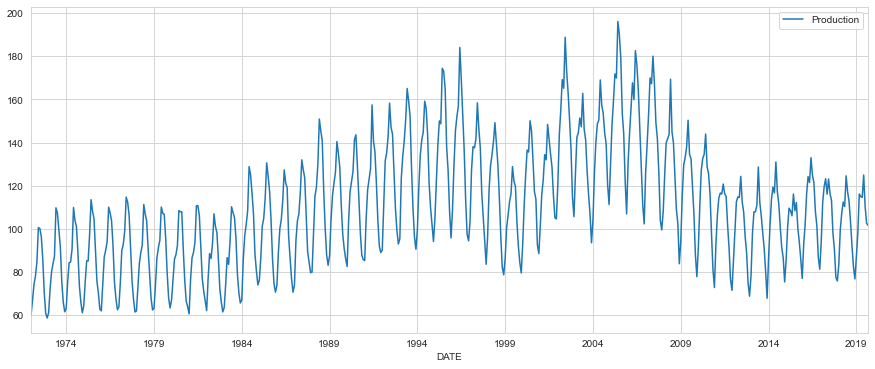

In [5]:
df.plot(figsize=(15,6));

## Preprocessing of Data

### Train Test Split

In [6]:
len(df)

573

In [7]:
len(df) - 18

555

In [8]:
test_size = 18
test_ind = len(df)- test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434


In [11]:
test

,Production
DATE,
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584
2018-07-01,117.222
2018-08-01,112.678
2018-09-01,103.312
2018-10-01,92.132
2018-11-01,82.435
2018-12-01,76.761


### Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
length = 12 # Bir cycle 12 ay olduğu için length i 12 seçtim
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [15]:
len(generator)

543

In [16]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [17]:
X, y = generator[0]

In [18]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [21]:
n_features = 1 # feature sayısı, bu data da 1 tane

### Creating Model

### with "tanh" activation function

In [22]:
model_tanh = Sequential()
model_tanh.add(LSTM(100, activation = 'tanh', input_shape = (length, n_features)))
model_tanh.add(Dense(1))
model_tanh.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model_tanh.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [25]:
model_tanh.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 5s 6ms/step - loss: 0.0221 - val_loss: 0.0016
Epoch 2/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0065


<AxesSubplot:>

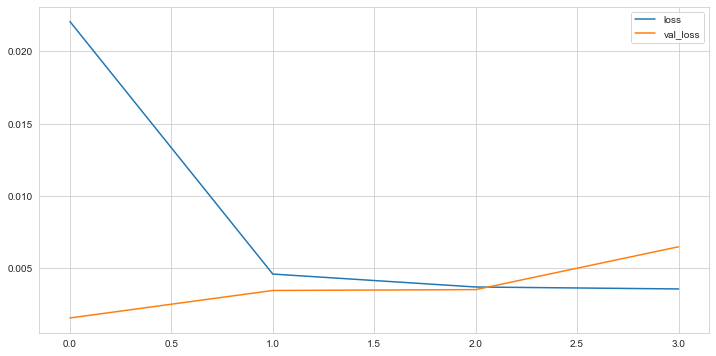

In [26]:
loss_df = pd.DataFrame(model_tanh.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [27]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model_tanh.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions_Tanh'] = true_predictions
test

,Production,Predictions_Tanh
DATE,,
2018-04-01,112.431,120.339
2018-05-01,110.354,128.715
2018-06-01,124.584,134.731
2018-07-01,117.222,135.194
2018-08-01,112.678,130.037
2018-09-01,103.312,118.705
2018-10-01,92.132,105.527
2018-11-01,82.435,94.171
2018-12-01,76.761,90.057


<AxesSubplot:xlabel='DATE'>

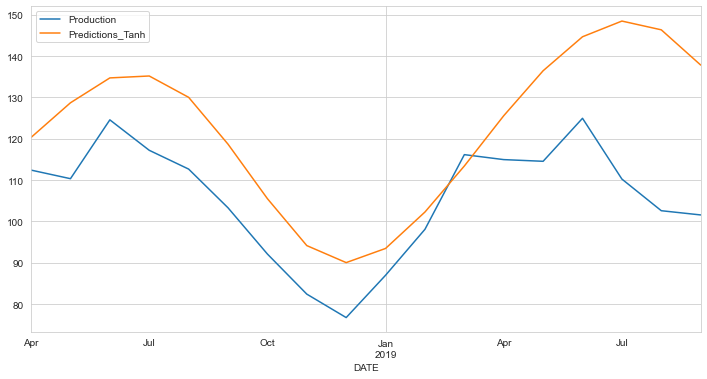

In [30]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [31]:
eval_metrics(test['Production'], test['Predictions_Tanh'])

r2_score: -1.3205805175487182 
mae: 17.19148879530065 
mse: 421.9911714207088 
rmse: 20.54242369879243


### with "relu" activation function

In [32]:
model_relu = Sequential()
model_relu.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model_relu.add(Dense(1))
model_relu.compile(optimizer = 'adam', loss = 'mse')

In [33]:
model_relu.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_relu.fit_generator(generator, epochs = 30,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/30
543/543 [==============================] - 4s 5ms/step - loss: 0.0257 - val_loss: 0.0019
Epoch 2/30
543/543 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0013
Epoch 3/30
543/543 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 4/30
543/543 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 5/30
543/543 [==============================] - 3s 5ms/step - loss: 0.0046 - val_loss: 0.0020


<AxesSubplot:>

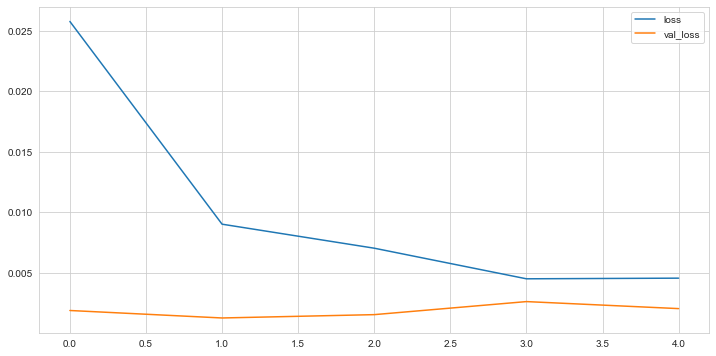

In [35]:
loss_df = pd.DataFrame(model_relu.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [36]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model_relu.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['Predictions_Relu'] = true_predictions
test

,Production,Predictions_Tanh,Predictions_Relu
DATE,,,
2018-04-01,112.431,120.339,115.575
2018-05-01,110.354,128.715,120.526
2018-06-01,124.584,134.731,123.155
2018-07-01,117.222,135.194,120.969
2018-08-01,112.678,130.037,112.608
2018-09-01,103.312,118.705,99.555
2018-10-01,92.132,105.527,86.252
2018-11-01,82.435,94.171,76.694
2018-12-01,76.761,90.057,75.682


<AxesSubplot:xlabel='DATE'>

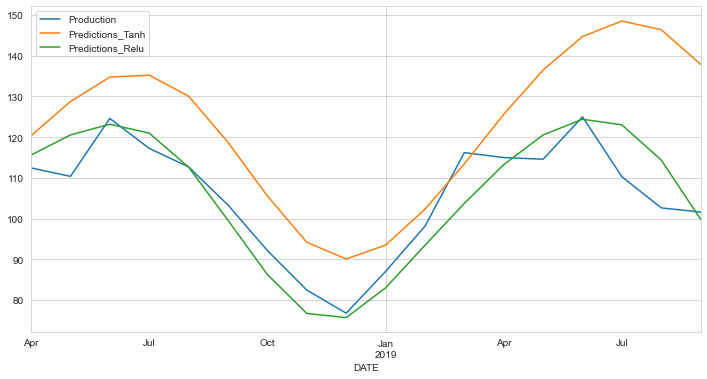

In [39]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [40]:
eval_metrics(test['Production'], test['Predictions_Relu'])

r2_score: 0.7717596003260104 
mae: 5.039120795273576 
mse: 41.504887632900484 
rmse: 6.442428706078204


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [43]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 4s 5ms/step - loss: 0.0153
Epoch 2/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0068
Epoch 3/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0064
Epoch 4/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0050
Epoch 5/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 6/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0041
Epoch 7/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 8/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0037
Epoch 9/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 10/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0032
Epoch 11/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0030
Epoch 12/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0028
Epoch 13/15
561/561 [====

In [44]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [45]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 89.68491586],
       [ 82.48062695],
       [ 80.18304041],
       [ 86.20817121],
       [ 97.83255257],
       [107.37924426],
       [113.34354703],
       [118.47449449],
       [121.11248236],
       [117.64420876],
       [110.92471629],
       [102.10330949],
       [ 91.01964907],
       [ 82.75341358],
       [ 79.30060261],
       [ 83.70803972],
       [ 94.4570138 ],
       [104.39262785],
       [111.88981342],
       [117.82166637],
       [121.20155747],
       [120.67067639],
       [115.52547937],
       [106.21257962]])

In [46]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [47]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [48]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,89.685
2019-11-01,82.481
2019-12-01,80.183
2020-01-01,86.208
2020-02-01,97.833
2020-03-01,107.379
2020-04-01,113.344
2020-05-01,118.474
2020-06-01,121.112
2020-07-01,117.644


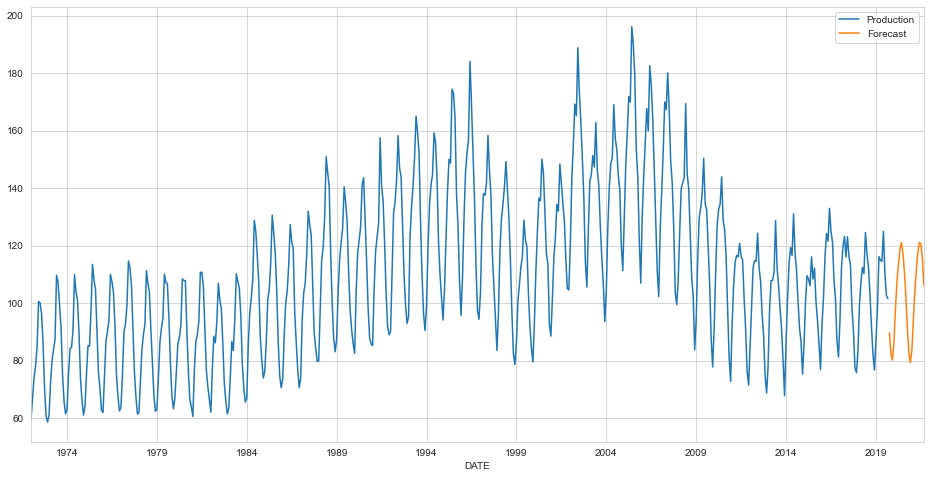

In [49]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

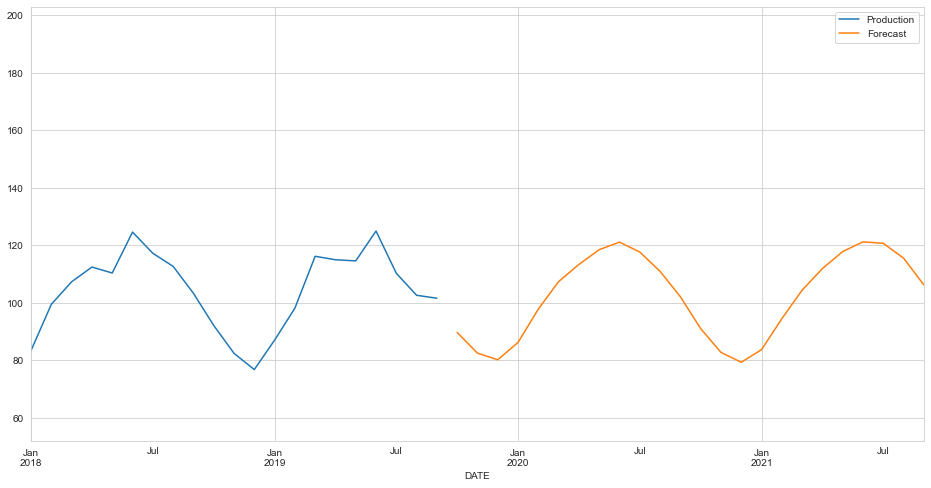

In [50]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')